#### Importing the necessary libraries

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from keras import models
from keras import layers,regularizers,optimizers
from keras.models import Sequential
from keras.layers import Dropout,Activation,LSTM,Dense,Embedding,Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder

#### Reading the data

In [110]:
df = pd.read_csv('tweet_product_company.csv',encoding='latin-1')
df.head(15)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


This is the data we have let us check the overall information of the dataset.

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


So as we can see the dataset has different count of values in the rows.
For the purpose of the project is sentiment analysis, I chose the columns the necessary columns from the dataset.

In [112]:
# Keeping the necessary columns
df = df[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]
df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion
...,...,...
9088,Ipad everywhere. #SXSW {link},Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,No emotion toward brand or product


#### Data Preprocessing

These columns have really long names so I renamed the column names to simplify the column names.

In [113]:
df.rename(columns = {'tweet_text' : 'text'},inplace=True)
df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product' : 'sentiment'},inplace=True)

There we have it the column names are better than before so let us process this dataset for sentiment analysis.

So now that we have the columns necessary in the dataset we can check the overall information of the dataset again.

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9092 non-null   object
 1   sentiment  9093 non-null   object
dtypes: object(2)
memory usage: 142.2+ KB


The dataset has columns with different range of row values but since the missing values are equal to 1. I chose to impute the missing value using a constant value.

In [115]:
df['text'] = df['text'].fillna(value='Unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9093 non-null   object
 1   sentiment  9093 non-null   object
dtypes: object(2)
memory usage: 142.2+ KB


Perfect! Now our columns have the same number of rows in data.

Let us continue exploring this dataset specifically the types of emotions in the 'sentiment' column as to identify what we are really dealing with.

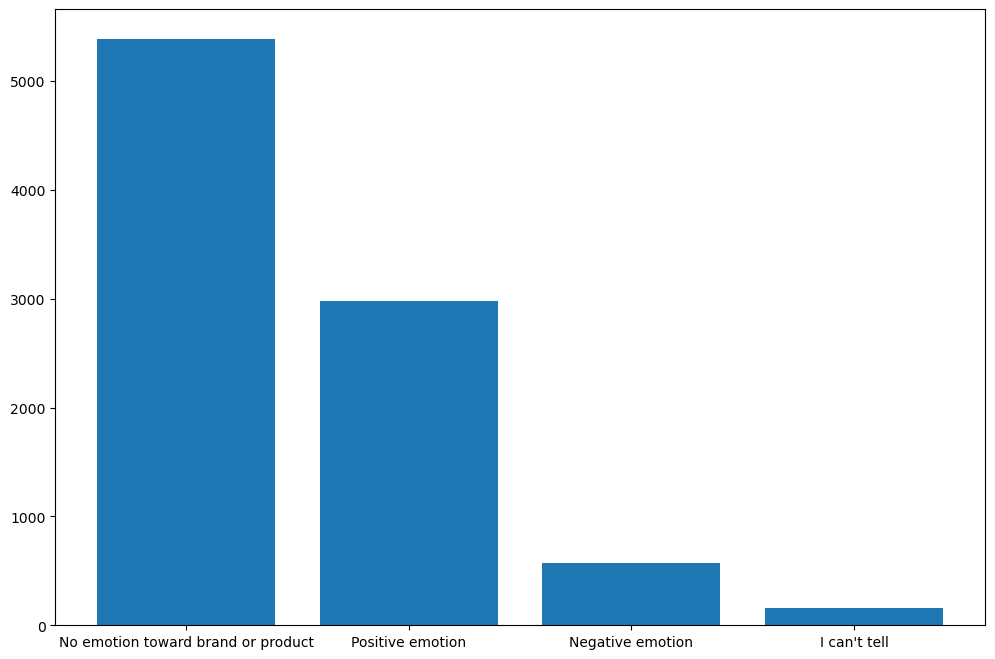

In [116]:
# Identifies the distribution between labels in the target variable 'sentiment'
sentiment_counts = df['sentiment'].value_counts()
labels = sentiment_counts.index
frequencies = sentiment_counts.values
plt.figure(figsize=(12,8))
plt.bar(labels,frequencies)
plt.show()

In [117]:
df['sentiment'].value_counts()

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

As we can see the dataset we have has four different types of emotions which are all valid. Let us start by building a binary classifier; this mean limiting the sentiment analysis to tweets that were identified as potraying negative or positive emotion.

(A multi-classifier will be built later)

In [118]:
data = df.copy()
data = data[data.sentiment != 'No emotion toward brand or product']
data = data[data.sentiment != "I can't tell"]
print(data[data['sentiment'] == 'Positive emotion'].size)
print(data[data['sentiment'] == 'Negative emotion'].size)

5956
1140


So what I have done in the cell above is made a copy of the dataset. The next step was to filter out the tweets that did not have positive or negative emotion as for a binary classifier I was only interested with positive and negative tweets.

There are many different approaches that are viable options for sentiment analysis and with experimentation of the options, the aim is to obtain the best possible solution. Let us begin with the automatic approaches that is machine learning models.

#### Getting ready for Deep NLP

Deep NLP involves the application the Recurrent Neural Network model which is a sequence model that is able to focus on order of words hence capturing information quite effectively.

Great! Now we have clean text with no special characters,stopwords and all lower case.
Lets s now deal with our target variable and encode labels before splitting it into the train,test and validation sets.

Great now we have clean text and labels that are in numerical form hence our machine learning models can work with.

Then I split the dataset into X and Y .

In [119]:
X = data['text']
y = data['sentiment']

In [120]:
# Preprocesses the text before tokenization
def preprocess_text(text):
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Join the processed words back into a single string
    processed_text = ' '.join(words)
    
    return processed_text

tweets = X
preprocessed_tweets = [preprocess_text(tweet) for tweet in tweets]
print(preprocessed_tweets)

# I one-hot encoded the target variable y converting y values to numerical features.
encoder = OneHotEncoder(sparse=False)
sentiment = np.array(y)
encoded = encoder.fit_transform(sentiment.reshape(-1,1))
print(encoded)

['wesley83 3g iphone 3 hrs tweeting rise_austin dead need upgrade plugin stations sxsw', 'jessedee know fludapp awesome ipadiphone app youll likely appreciate design also theyre giving free ts sxsw', 'swonderlin wait ipad 2 also sale sxsw', 'sxsw hope years festival isnt crashy years iphone app sxsw', 'sxtxstate great stuff fri sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress', 'sxsw starting ctia around corner googleio hop skip jump good time android fan', 'beautifully smart simple idea rt madebymany thenextweb wrote hollergram ipad app sxsw httpbitlyieavob', 'counting days sxsw plus strong canadian dollar means stock apple gear', 'excited meet samsungmobileus sxsw show sprint galaxy still running android 21 fail', 'find amp start impromptu parties sxsw hurricaneparty httpbitlygvlrin cant wait til android app comes', 'foursquare ups game time sxsw httpjmpgrn7pk still prefer gowalla far best looking android app date', 'gotta love sxsw google cale

c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Great! now we have text clean of special characters and punctuation, text in lower case and text that does not have stop words.

We also now have our target variable in labelled classes.

Train-Test split

The data is split into training and test sets and in this case I assigned 1500 observations to the test and seed to 42.

In [121]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_tweets,encoded,test_size=1500,random_state=42)

I created a Validation set as well as the model created is highly likely to be subject to hyperparameter tuning, and so the validation set will be used until a final model is decided upon. The final model will then be tested on the unseen test data that will provide an unbiased performance of the final model.

In [122]:
# Splits data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train,y_train,test_size=1000,random_state=42)


I used Tokenizer from keras preprocessing:  

Tokenizer is a class provided by Keras, specifically designed 
for text tokenization and preprocessing in deep learning models.

This tokenizer also converts tokens to sequences.

In [123]:
# Let us create a function to do this as we will do this a couple more times
def preprocess_text_data(X_train, X_test, X_val, num_words=2000):
    # Create and fit the tokenizer
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(X_train + X_val + X_test)

    # Convert text sequences to token sequences
    X_train_token = tokenizer.texts_to_sequences(X_train)
    X_test_token = tokenizer.texts_to_sequences(X_test)
    X_val_token = tokenizer.texts_to_sequences(X_val)

    # Find the maximum sequence length
    max_sequence_length = max(len(seq) for seq in X_train_token + X_val_token + X_test_token)

    # Pad sequences
    train_padded_sequences = pad_sequences(X_train_token, maxlen=max_sequence_length)
    test_padded_sequences = pad_sequences(X_test_token, maxlen=max_sequence_length)
    val_padded_sequences = pad_sequences(X_val_token, maxlen=max_sequence_length)

    # Reshape sequences
    train_padded_sequences = train_padded_sequences.reshape(train_padded_sequences.shape[0], train_padded_sequences.shape[1], 1)
    test_padded_sequences = test_padded_sequences.reshape(test_padded_sequences.shape[0], test_padded_sequences.shape[1], 1)
    val_padded_sequences = val_padded_sequences.reshape(val_padded_sequences.shape[0], val_padded_sequences.shape[1], 1)

    return train_padded_sequences, test_padded_sequences, val_padded_sequences

# Calling the function on the split data
train_padded_sequences, test_padded_sequences, val_padded_sequences = preprocess_text_data(X_train_final, X_test, X_val,num_words=2000)

The sequences above are now fully converted into integers but to be able to fit an RNN model.


The next step is to compose a LSTM network which is part of RNN architecure. 

But first let us use the technique that is word embeddings to convert these sequences of integers into vector representations.

Word Embeddings are dense vector representations of words in a high-dimensional space. The purpose of word embeddings is to capture the meaning and interpretation of words; semantic relationships that is.

Word embeddings have benefits such as representing text/words as dense vectors of fixed dimensions allowing for much more efficient storage and computation, among other things such as capturing semantic relationships.

Word embeddings prove to be very useful to an LSTM network as the model is able to effectively process sequential data,generaliz well and leverage pre-trained linguistic knowledge.

In [124]:
# In this case I used an embedding layer that is a layer that
# learns word embeddings for our dataset right inside a neural
# network


#### Baseline Model

I defined the network architecture and added number of layers as well as activation functions.

I also added regularization layers (Dropout) to the network to prevent overfitting the model.

In [125]:
#Input shape is the vocabulary size
embedding_size = 128
model = Sequential()
model.add(Embedding(2000, embedding_size))
model.add(LSTM(64, input_shape=(22,1)))
model.add(Dropout(0.2))
model.add(Dense(2,activation='sigmoid'))# Use 2 units in output layer for binary classification. 


Once you have designed the model, you still have to compile it, and provide important parameters such as the loss function.

Since I started with binary classification I used 'adam' as the optimizer. 

Adam is used for its robust performance on a wide range of tasks and is often a good choice for binary classification. 

In [126]:
# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

I used the metric accuracy as according to our business 
understanding I needed to build a model that will accurately rate the sentiment from a tweet based on its content.

In [127]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 128)         256000    
                                                                 
 lstm_12 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 2)                 130       
                                                                 
Total params: 305538 (1.17 MB)
Trainable params: 305538 (1.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Finally, I fit the model by passing in data, the labels and setting hyperparameters such as the batch size, number of epochs to train for and training and validation data.

In [128]:
baseline_model_val = model.fit(train_padded_sequences,y_train_final,validation_data=
          (val_padded_sequences,y_val),epochs=150,batch_size=32)

Epoch 1/150


33/33 [==============================] - 5s 45ms/step - loss: 0.5029 - accuracy: 0.8397 - val_loss: 0.4488 - val_accuracy: 0.8290
Epoch 2/150
33/33 [==============================] - 1s 32ms/step - loss: 0.3722 - accuracy: 0.8464 - val_loss: 0.4066 - val_accuracy: 0.8290
Epoch 3/150
33/33 [==============================] - 1s 22ms/step - loss: 0.2577 - accuracy: 0.8750 - val_loss: 0.3824 - val_accuracy: 0.8460
Epoch 4/150
33/33 [==============================] - 1s 26ms/step - loss: 0.1530 - accuracy: 0.9513 - val_loss: 0.4619 - val_accuracy: 0.8250
Epoch 5/150
33/33 [==============================] - 1s 38ms/step - loss: 0.0928 - accuracy: 0.9733 - val_loss: 0.5176 - val_accuracy: 0.8490
Epoch 6/150
33/33 [==============================] - 1s 20ms/step - loss: 0.0515 - accuracy: 0.9885 - val_loss: 0.5662 - val_accuracy: 0.8300
Epoch 7/150
33/33 [==============================] - 1s 18ms/step - loss: 0.0280 - accuracy: 0.9943 - val_loss: 0.7695 - val_accuracy: 0.8460
Epoch 8/150
33/33 

The model above is the first binary classifier built to and four entries were being monitored during training and validation one metric per entry.

In [129]:
baseline_model_dict = baseline_model_val.history
print(baseline_model_dict.keys())
# As we can see loss and accuracy were the metrics being monitored during training and validation.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [130]:
# Lets evaluate the model on the training data
results_train = model.evaluate(train_padded_sequences,y_train_final)
print (f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

33/33 [==============================] - 0s 8ms/step - loss: 9.5760e-07 - accuracy: 1.0000
Training Loss: 9.58e-07 
Training Accuracy: 1.0


In [131]:
# Lets evaluate the model on the test data
results_test = model.evaluate(test_padded_sequences,y_test)
print (f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

47/47 [==============================] - 0s 8ms/step - loss: 2.1178 - accuracy: 0.8113
Test Loss: 2.12 
Test Accuracy: 0.811


In [132]:
# Let us use this function to visualize loss and accuracy for training and validation loss and accuracy
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

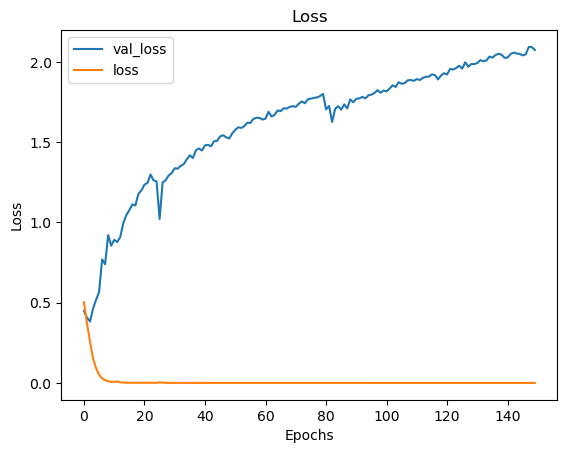

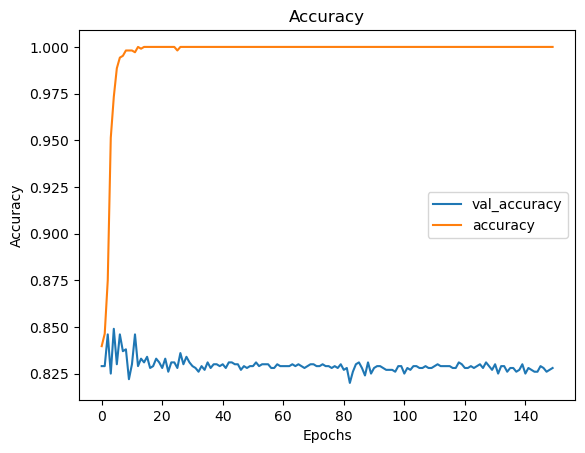

In [133]:
# Displaying loss and accuracy for the baseline model
visualize_training_results(baseline_model_val)

There seems to be overfitting of the neural networks, something that we need to avoid. We cannot know the precise number of epochs that we need to trian the model as it is a time consuming process but what we can do is apply early stopping a regularization technique that stops the training process before the model starts to overfit the training data.
This prevents the model from learning the noise present in the training data.

In [134]:
# Defining the callbacks
early_stopping = [EarlyStopping(patience=10,monitor='val_loss'),
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_2_val = model.fit(train_padded_sequences,y_train_final,validation_data=
          (val_padded_sequences,y_val),epochs=150,batch_size=32,callbacks=early_stopping)

Epoch 1/150
33/33 [==============================] - 1s 20ms/step - loss: 1.3720e-06 - accuracy: 1.0000 - val_loss: 2.0766 - val_accuracy: 0.8270
Epoch 2/150
 8/33 [======>.......................] - ETA: 0s - loss: 1.6623e-06 - accuracy: 1.0000

c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 1s 24ms/step - loss: 1.2638e-06 - accuracy: 1.0000 - val_loss: 2.0765 - val_accuracy: 0.8270
Epoch 3/150
33/33 [==============================] - 1s 28ms/step - loss: 1.8075e-06 - accuracy: 1.0000 - val_loss: 2.0945 - val_accuracy: 0.8250
Epoch 4/150
33/33 [==============================] - 1s 24ms/step - loss: 1.2150e-06 - accuracy: 1.0000 - val_loss: 2.1045 - val_accuracy: 0.8250
Epoch 5/150
33/33 [==============================] - 1s 22ms/step - loss: 2.0134e-06 - accuracy: 1.0000 - val_loss: 2.0761 - val_accuracy: 0.8270
Epoch 6/150
33/33 [==============================] - 1s 30ms/step - loss: 1.7398e-06 - accuracy: 1.0000 - val_loss: 2.0980 - val_accuracy: 0.8260
Epoch 7/150
33/33 [==============================] - 1s 29ms/step - loss: 1.5146e-06 - accuracy: 1.0000 - val_loss: 2.1078 - val_accuracy: 0.8250
Epoch 8/150
33/33 [==============================] - 1s 19ms/step - loss: 1.2191e-06 - accuracy: 1.0000 - val_loss: 2.1345 - val_accurac

In [135]:
# Let us load the best saved model from the training above
from keras.models import load_model
saved_model = load_model('best_model.h5')

# Lets evaluate the best model on the training data
result_train = saved_model.evaluate(train_padded_sequences,y_train_final)
print (f'Training Loss: {result_train[0]:.3} \nTraining Accuracy: {result_train[1]:.3}')

# Lets evaluate the best model on the test data
results_test = saved_model.evaluate(test_padded_sequences,y_test)
print (f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

33/33 [==============================] - 2s 11ms/step - loss: 2.1295e-06 - accuracy: 1.0000
Training Loss: 2.13e-06 
Training Accuracy: 1.0
47/47 [==============================] - 0s 7ms/step - loss: 2.0846 - accuracy: 0.8207
Test Loss: 2.08 
Test Accuracy: 0.821


According to our results the model that Early model regularization technique has considered its best model results is the results at 19 epochs

This is great as it goes to show the model stopped training before it could overfit data and those were our results.

We could continue applying hyperparameter tuning to the the baseline model but I will choose to proceed to building a multi-class classifier.

### Building A Multi-class Classifier

Building a multi-class classifier means having a target variable with more than two classes.

In the original dataset we had four classes in the target variable sentiment and now we want to build a classifier that will allow more than two classes.

As recalled the target had the below classes with the respective corresponding number of column values.

In [136]:
df['sentiment'].value_counts()
# We can see the four classes here clearly.

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

Splitting the data into X and y

In [137]:
X = df['text']
y = df['sentiment']

I encoded the target variables to turn them into numerical features that can be fed to a machine learning model.

In [138]:
# Assume you have your target labels stored in a variable called `y`
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform the target labels
encoded_y = label_encoder.fit_transform(y)
np.unique(encoded_y)

array([0, 1, 2, 3])

Great, so the target labels have been converted to numerical features.

In [139]:
# Let us convert predictor variable X from unclean text to clean text
tweets_1 = X
# Using the function from before to clean the text X variable
preprocessed_tweets_1 = [preprocess_text(tweet) for tweet in tweets_1]
print(preprocessed_tweets_1)


['wesley83 3g iphone 3 hrs tweeting rise_austin dead need upgrade plugin stations sxsw', 'jessedee know fludapp awesome ipadiphone app youll likely appreciate design also theyre giving free ts sxsw', 'swonderlin wait ipad 2 also sale sxsw', 'sxsw hope years festival isnt crashy years iphone app sxsw', 'sxtxstate great stuff fri sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress', 'teachntech00 new ipad apps speechtherapy communication showcased sxsw conference httphtly49n4m iear edchat asd', 'unknown', 'sxsw starting ctia around corner googleio hop skip jump good time android fan', 'beautifully smart simple idea rt madebymany thenextweb wrote hollergram ipad app sxsw httpbitlyieavob', 'counting days sxsw plus strong canadian dollar means stock apple gear', 'excited meet samsungmobileus sxsw show sprint galaxy still running android 21 fail', 'find amp start impromptu parties sxsw hurricaneparty httpbitlygvlrin cant wait til android app comes', 'four

In [140]:
# Split data into training and test sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(preprocessed_tweets_1,encoded_y,test_size=1500,random_state=42)

# Split data into training and test sets
X_train_last, X_val_1, y_train_last, y_val_1 = train_test_split(X_train_1,y_train_1,test_size=1500,random_state=42)

In [141]:
# Calling the tokenization function on the split data
train_padded_sequences_1, test_padded_sequences_1, val_padded_sequences_1 = preprocess_text_data(X_train_last, X_test_1, X_val_1,num_words=2000)

In [142]:
num_classes = 4 # because target variable y has four classes
input_shape = (22, 1)  # Assuming input sequences of length 100 with 1 feature

# Create the LSTM model
model_1 = models.Sequential()
embedding_size = 56
model_1.add(Embedding(2000, embedding_size))
model_1.add(layers.LSTM(64, input_shape=input_shape))
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(num_classes, activation='softmax'))# The outpt layer needs to have units similar to number of classes present

# Compile the model
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#sparse_categorical_crossentropy is the loss function used because the labels we have are converted to integers

# Print a summary of the model architecture
model_1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 56)          112000    
                                                                 
 lstm_13 (LSTM)              (None, 64)                30976     
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 4)                 260       
                                                                 
Total params: 147396 (575.77 KB)
Trainable params: 147396 (575.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [143]:
# Fitting the model on training data and validation data
multi_model_val = model_1.fit(train_padded_sequences_1,y_train_last,validation_data=
          (val_padded_sequences_1,y_val_1),epochs=120,batch_size=32)


Epoch 1/120
191/191 [==============================] - 8s 17ms/step - loss: 0.9381 - accuracy: 0.5912 - val_loss: 0.8502 - val_accuracy: 0.6260
Epoch 2/120
191/191 [==============================] - 3s 18ms/step - loss: 0.7472 - accuracy: 0.6828 - val_loss: 0.8029 - val_accuracy: 0.6633
Epoch 3/120
191/191 [==============================] - 3s 16ms/step - loss: 0.6245 - accuracy: 0.7440 - val_loss: 0.8242 - val_accuracy: 0.6740
Epoch 4/120
191/191 [==============================] - 3s 13ms/step - loss: 0.5561 - accuracy: 0.7740 - val_loss: 0.8591 - val_accuracy: 0.6527
Epoch 5/120
191/191 [==============================] - 3s 18ms/step - loss: 0.5052 - accuracy: 0.7883 - val_loss: 0.9125 - val_accuracy: 0.6587
Epoch 6/120
191/191 [==============================] - 3s 15ms/step - loss: 0.4579 - accuracy: 0.8080 - val_loss: 0.9869 - val_accuracy: 0.6213
Epoch 7/120
191/191 [==============================] - 2s 12ms/step - loss: 0.4165 - accuracy: 0.8227 - val_loss: 1.0468 - val_accuracy:

In [144]:
# Let us evaluate the model on the training data
loss, accuracy = model_1.evaluate(train_padded_sequences_1,y_train_last)
print (f'Training loss and Training accuracy {loss,accuracy}')
#Lets evaluate the model on test data
loss, accuracy = model_1.evaluate(test_padded_sequences_1,y_test_1)
print (f'Test loss and Test accuracy {loss,accuracy}')

191/191 [==============================] - 1s 6ms/step - loss: 0.0134 - accuracy: 0.9934
Training loss and Training accuracy (0.013416214846074581, 0.9934350848197937)
47/47 [==============================] - 0s 6ms/step - loss: 5.2164 - accuracy: 0.5973
Test loss and Test accuracy (5.216363430023193, 0.5973333120346069)


Loss and accuracy are the metrics that are monitored during training of nueral networks and so for each entry (training and validation data), each has one metric that is monitored.

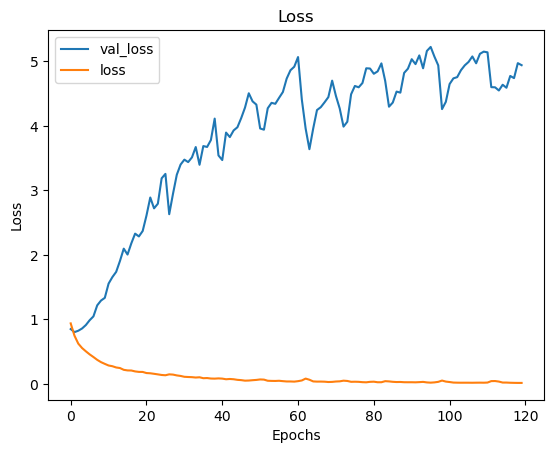

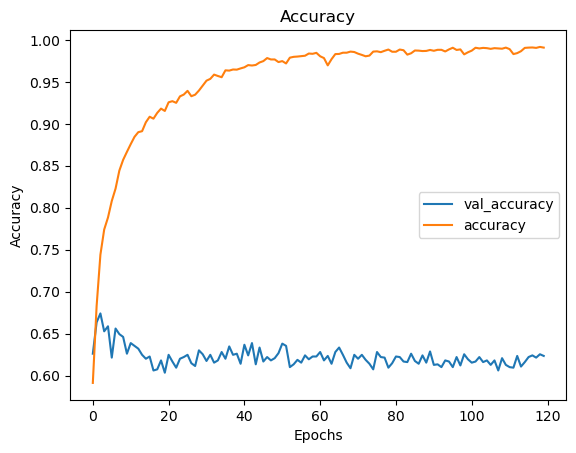

In [145]:
# Visualizing multi-class classifier model results
visualize_training_results(multi_model_val)

There is clear overfitting present in this model. Let us tune this network with regularization techniques to deal with this overfitting.

In [146]:
# Create the LSTM network
model_3 = models.Sequential()
embedding_size = 128
model_3.add(Embedding(2000, embedding_size))
model_3.add(layers.LSTM(56, input_shape=input_shape))# In this case we will apply dropout regularization
model_3.add(Dropout(0.5))
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(layers.Dense(num_classes, activation='softmax'))# The outpt layer needs to have units similar to number of classes present

# Compile the model
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#sparse_categorical_crossentropy is the loss function used because the labels we have are converted to integers

# Print a summary of the model architecture
model_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 128)         256000    
                                                                 
 lstm_14 (LSTM)              (None, 56)                41440     
                                                                 
 dropout_13 (Dropout)        (None, 56)                0         
                                                                 
 dense_23 (Dense)            (None, 64)                3648      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 4)                 260       
                                                                 
Total params: 301348 (1.15 MB)
Trainable params: 3013

In [147]:
# Our target variable has a class imbalance that needs to be addressed.
class_weights = dict(enumerate(1/np.bincount(y_train_last)))
# When class weights are calculated, the model assigns higher penalties to the minority classes during training, 
# helping address the issue of class imbalance
sample_weights = np.array([class_weights[class_label] for class_label in y_train_last])
# Fitting the model on training data and validation data
second_multi_model_val = model_3.fit(train_padded_sequences_1,y_train_last,validation_data=
          (val_padded_sequences_1,y_val_1),epochs=100,batch_size=32,sample_weight=sample_weights)

Epoch 1/100
191/191 [==============================] - 7s 21ms/step - loss: 9.0784e-04 - accuracy: 0.3468 - val_loss: 1.3377 - val_accuracy: 0.4853
Epoch 2/100
191/191 [==============================] - 3s 14ms/step - loss: 8.7030e-04 - accuracy: 0.3776 - val_loss: 1.3033 - val_accuracy: 0.4107
Epoch 3/100
191/191 [==============================] - 3s 16ms/step - loss: 7.6653e-04 - accuracy: 0.4243 - val_loss: 1.3051 - val_accuracy: 0.3933
Epoch 4/100
191/191 [==============================] - 3s 15ms/step - loss: 6.2251e-04 - accuracy: 0.4755 - val_loss: 1.1411 - val_accuracy: 0.4547
Epoch 5/100
191/191 [==============================] - 3s 16ms/step - loss: 5.0044e-04 - accuracy: 0.5272 - val_loss: 1.0906 - val_accuracy: 0.4873
Epoch 6/100
191/191 [==============================] - 3s 18ms/step - loss: 4.0673e-04 - accuracy: 0.5802 - val_loss: 1.3063 - val_accuracy: 0.4387
Epoch 7/100
191/191 [==============================] - 4s 19ms/step - loss: 3.8293e-04 - accuracy: 0.6120 - val_

In [148]:
# Let us evaluate the model on the training data
loss, accuracy = model_3.evaluate(train_padded_sequences_1,y_train_last)
print (f'Training loss and Training accuracy {loss,accuracy}')
#Lets evaluate the model on test data
loss, accuracy = model_3.evaluate(test_padded_sequences_1,y_test_1)
print (f'Test loss and Test accuracy {loss,accuracy}')

191/191 [==============================] - 1s 7ms/step - loss: 0.0692 - accuracy: 0.9708
Training loss and Training accuracy (0.06922326982021332, 0.9707861542701721)
47/47 [==============================] - 1s 11ms/step - loss: 4.2837 - accuracy: 0.5927
Test loss and Test accuracy (4.283726215362549, 0.5926666855812073)


As we can see the accuracy of the model has decreased but one the bright side the loss of the model has also decreased meaning that the point is 4.28 units off in its predictions than in the first multi-class model, the model was 5.21 units far off. The accuracy of the training data has also decreased showing the model has also dealt with overfitting quite abit.

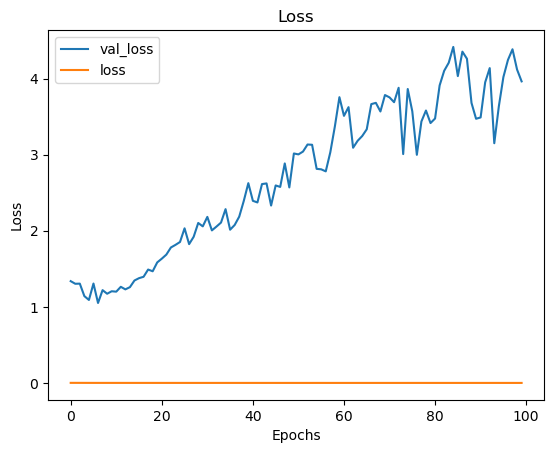

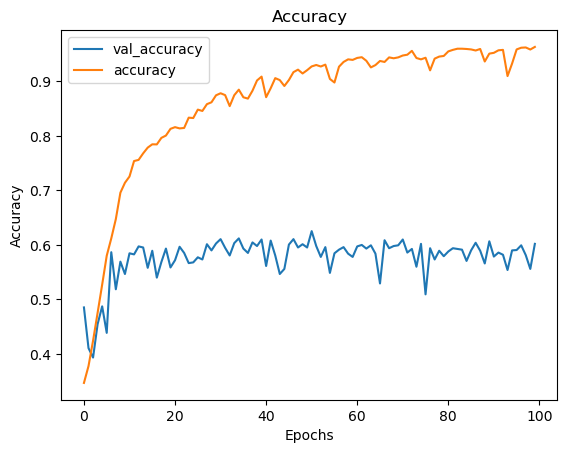

In [149]:
visualize_training_results(second_multi_model_val)

It seems this multi-class classifier will not light up! Let us consider increasing the training data and see what changes!

Let us also use L2 regularization;L2 regularization can help prevent the model from overly relying on specific features or classes, leading to a more balanced and robust classifier.

In [150]:
# Calling the vectorization function on the split data
train_padded_sequences_2, test_padded_sequences_2, val_padded_sequences_2 = preprocess_text_data(X_train_last, X_test_1, X_val_1,num_words=5000)

num_classes = 4 # because target variable y has four classes
input_shape = (22, 1)  # Assuming input sequences of length 100 with 1 feature

# Create the LSTM model
model_4 = models.Sequential()
embedding_size = 128
model_4.add(Embedding(5000, embedding_size))
model_4.add(layers.LSTM(56, input_shape=input_shape))
model_4.add(Dropout(0.5))
model_4.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_4.add(Dropout(0.5))
model_4.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_4.add(layers.Dense(num_classes, activation='softmax'))# The outpt layer needs to have units similar to number of classes present

# Compile the model
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#sparse_categorical_crossentropy is the loss function used because the labels we have are converted to integers

# Print a summary of the model architecture
model_4.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 128)         640000    
                                                                 
 lstm_15 (LSTM)              (None, 56)                41440     
                                                                 
 dropout_15 (Dropout)        (None, 56)                0         
                                                                 
 dense_25 (Dense)            (None, 64)                3648      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 4)               

In [152]:
# Fitting the model on training data
third_multi_model_val = model_4.fit(train_padded_sequences_1,y_train_last,validation_data=
          (val_padded_sequences_1,y_val_1),epochs=90,batch_size=32,sample_weight=sample_weights)

Epoch 1/90
191/191 [==============================] - 9s 32ms/step - loss: 0.4210 - accuracy: 0.2982 - val_loss: 1.4453 - val_accuracy: 0.0660
Epoch 2/90
191/191 [==============================] - 6s 30ms/step - loss: 0.0151 - accuracy: 0.0945 - val_loss: 1.3891 - val_accuracy: 0.0187
Epoch 3/90
191/191 [==============================] - 4s 21ms/step - loss: 0.0011 - accuracy: 0.1315 - val_loss: 1.3860 - val_accuracy: 0.0660
Epoch 4/90
191/191 [==============================] - 5s 24ms/step - loss: 9.1087e-04 - accuracy: 0.4389 - val_loss: 1.3886 - val_accuracy: 0.0660
Epoch 5/90
191/191 [==============================] - 4s 21ms/step - loss: 9.1028e-04 - accuracy: 0.0906 - val_loss: 1.3893 - val_accuracy: 0.0660
Epoch 6/90
191/191 [==============================] - 4s 21ms/step - loss: 9.1028e-04 - accuracy: 0.0752 - val_loss: 1.3874 - val_accuracy: 0.0660
Epoch 7/90
191/191 [==============================] - 4s 23ms/step - loss: 9.1022e-04 - accuracy: 0.0607 - val_loss: 1.3870 - val_

In [153]:
# Let us evaluate the model on the training data
loss, accuracy = model_4.evaluate(train_padded_sequences_1,y_train_last)
print (f'Training loss and Training accuracy {loss,accuracy}')
#Lets evaluate the model on test data
loss, accuracy = model_4.evaluate(test_padded_sequences_1,y_test_1)
print (f'Test loss and Test accuracy {loss,accuracy}')

191/191 [==============================] - 1s 7ms/step - loss: 1.3863 - accuracy: 0.3296
Training loss and Training accuracy (1.3862582445144653, 0.32955852150917053)
47/47 [==============================] - 0s 7ms/step - loss: 1.3863 - accuracy: 0.3260
Test loss and Test accuracy (1.3862709999084473, 0.32600000500679016)


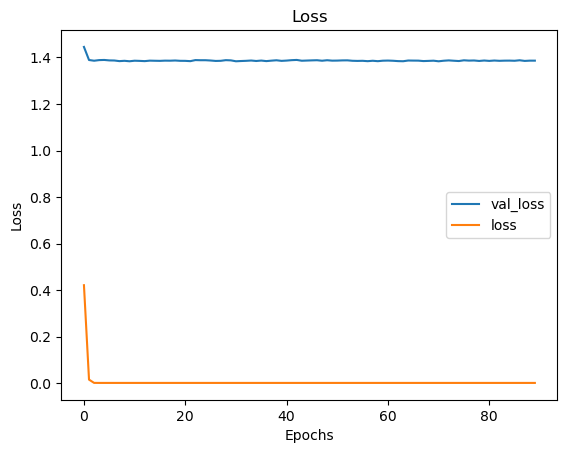

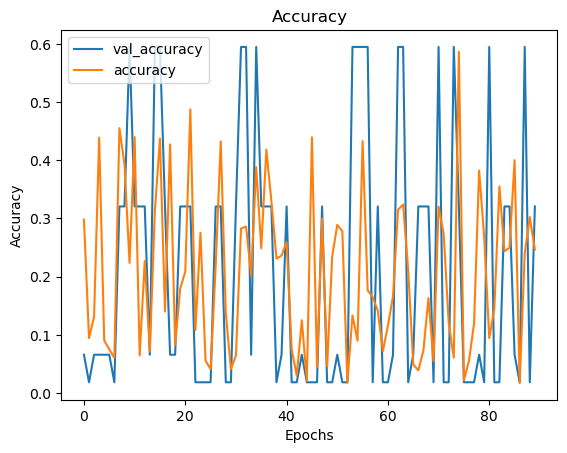

In [154]:
visualize_training_results(third_multi_model_val)

In [151]:
# def preprocess(textdata):
#     processedText = []
    
#     # Create Lemmatizer and Stemmer.
#     wordLemm = WordNetLemmatizer()
    
#     # Defining regex patterns.
#     urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
#     userPattern       = '@[^\s]+'
#     alphaPattern      = "[^a-zA-Z0-9]"
#     sequencePattern   = r"(.)\1\1+"
#     seqReplacePattern = r"\1\1"
    
#     for tweet in textdata:
#         tweet = tweet.lower()
        
#         # Replace all URls with 'URL'
#         tweet = re.sub(urlPattern,' URL',tweet)
#         # Replace all emojis.
#         for emoji in emojis.keys():
#             tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
#         # Replace @USERNAME to 'USER'.
#         tweet = re.sub(userPattern,' USER', tweet)        
#         # Replace all non alphabets.
#         tweet = re.sub(alphaPattern, " ", tweet)
#         # Replace 3 or more consecutive letters by 2 letter.
#         tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

#         tweetwords = ''
#         for word in tweet.split():
#             # Checking if the word is a stopword.
            #if word not in stopwordlist:
    #         if len(word)>1:
    #             # Lemmatizing the word.
    #             word = wordLemm.lemmatize(word)
    #             tweetwords += (word+' ')
            
    #     processedText.append(tweetwords)
        
    # return processedText
#     vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
# vectoriser.fit(X_train)
# print(f'Vectoriser fitted.')
# print('No. of feature_words: ', len(vectoriser.get_feature_names()))